# 목적 : 단어 Level로 번역기 업그레이드하기

In [1]:
# 필요한 도구 import
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import re

In [2]:
# 해당 파일을 데이터프레임으로 읽어옵니다.
file_path = '/content/drive/MyDrive/AIFFEL/[E-10]/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 194513


,eng,fra,cc
127940,I fell asleep listening to music.,Je me suis endormie en écoutant de la musique.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
7961,It smells bad.,Ça sent mauvais.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
121435,I did not understand him at all.,Je ne le compris pas du tout.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
187474,"If for some reason that should happen, what wo...","Si, pour une raison quelconque, cela devait ar...",CC-BY 2.0 (France) Attribution: tatoeba.org #1...
56452,I saw a flock of sheep.,J'ai vu un troupeau de moutons.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [3]:
# 세번째 열은 불필요하므로 제거하고, 훈련 데이터는 33000개의 샘플로 줄이겠습니다.
lines = lines[['eng', 'fra']][:33000] # 33000개 샘플 사용
lines.sample(5)

,eng,fra
26053,They're after you.,Elles sont après vous.
1104,I see you.,Je te vois.
14158,I love eggplant.,J'adore les aubergines.
24511,I'm doing my duty.,Je fais mon devoir.
19813,Maybe Tom forgot.,Peut-être que Tom a oublié.


In [4]:
# pandas로 불러온 데이터들을 ndarray 형태로 변환
lines_np_eng= lines['eng'].to_numpy()
lines_np_fra= lines['fra'].to_numpy()
lines_np_eng

array(['Go.', 'Go.', 'Go.', ..., 'What did they want?',
       'What did they want?', 'What did you drink?'], dtype=object)

### 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

In [5]:
# 구두점 분리 및 소문자 변경
sos_token = '<start> '
eos_token = ' <end>'

def preprocess_line(line, plus_token = True):
    # 소문자로 변경하기
    line = line.lower().strip()
    # 구두점(Punctuation)을 단어와 분리하기
    line = re.sub(r"([?.!,¿])", r" \1 ", line)
    line = re.sub(r'[" "]+', " ", line)
    line = re.sub(r"[^a-zA-Z?.!,¿]+", " ", line)

    line = line.strip()
    
    if plus_token == True:
        line = sos_token + line + eos_token
    
    return line

In [6]:
#  띄어쓰기 단위로 토큰를 수행
def tokenize(corpus):
    tokenizer = Tokenizer(
        num_words=12000,  
        filters=' ',   
        oov_token="<unk>"  
    )
    tokenizer.fit_on_texts(corpus)  

    tensor = tokenizer.texts_to_sequences(corpus)   

    return tensor, tokenizer

In [7]:
# 영어, 프랑스어 전처리하기
eng_lines = []
fra_lines = []

for eng, fra in zip(lines.eng, lines.fra):
    if len(eng) == 0: continue
    if len(fra) == 0: continue   
        
    eng_lines.append(preprocess_line(eng, plus_token = False))
    fra_lines.append(preprocess_line(fra))

In [8]:
# 토큰화
eng_tensor, eng_tokenizer = tokenize(eng_lines)
fra_tensor, fra_tokenizer = tokenize(fra_lines)
fra_tensor[:10]

[[2, 77, 9, 3],
 [2, 380, 4, 3],
 [2, 720, 9, 3],
 [2, 749, 9, 3],
 [2, 749, 4, 3],
 [2, 679, 9, 3],
 [2, 1884, 9, 3],
 [2, 184, 268, 1035, 268, 2629, 9, 3],
 [2, 1331, 9, 3],
 [2, 2183, 9, 3]]

In [9]:
# 단어장의 크기를 변수로 저장
# 0번 토큰을 고려하여 +1을 하고 저장
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4673
프랑스어 단어장의 크기 : 7462


In [10]:
# 영어 데이터와 프랑스어 데이터의 최대 길이를 각각 구해보겠습니다
# 패딩(<pad>)을 위함
max_eng_seq_len = max([len(line) for line in eng_tensor])
max_fra_seq_len = max([len(line) for line in fra_tensor])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [11]:
# 전체적인 통계 정보를 한꺼번에 출력
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4673
프랑스어 단어장의 크기 : 7462
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [12]:
encoder_input = eng_tensor
# 종료 토큰 제거
decoder_input = [[char for char in line if char != fra_tokenizer.word_index['<end>']] for line in fra_tensor]
# 시작 토큰 제거
decoder_target =[[char for char in line if char != fra_tokenizer.word_index['<start>']] for line in fra_tensor]

In [13]:
# 디코더의 입력과 출력을 각각 출력
print(decoder_input[:3])
print(decoder_target[:3])

[[2, 77, 9], [2, 380, 4], [2, 720, 9]]
[[77, 9, 3], [380, 4, 3], [720, 9, 3]]


In [14]:
# 패딩 진행
# 영어 데이터의 모든 샘플들은 max_eng_seq_len의 길이
# 프랑스어의 모든 샘플들은 max_fra_seq_len의 길이
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 17)
프랑스어 출력데이터의 크기(shape) : (33000, 17)


In [15]:
# 인코더의 샘플 하나만 출력
print(encoder_input[0])

[30  2  0  0  0  0  0  0]


In [16]:
# 훈련과정의 validation을 위해 위에서 생성한 데이터 33000건 중 3000건만 검증데이터로 삼고, 나머지를 학습데이터로 삼겠습니다
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 17)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 17)


In [17]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking, Dropout
from tensorflow.keras.models import Model

embedding_size = 512
hidden_size = 512
# 인코더 설계
encoder_inputs = Input(shape=(None, ), name='encoder_input')
enc_emb =  Embedding(eng_vocab_size, embedding_size,
                    input_length=max_eng_seq_len)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(hidden_size, dropout = 0.5, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

In [18]:
# 디코더 설계
decoder_inputs = Input(shape=(None, ), name='decoder_input')
dec_emb =  Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(hidden_size, dropout = 0.5, return_sequences = True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state = encoder_states)

In [19]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [20]:
# # 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 512)    2392576     ['encoder_input[0][0]']          
                                                                                                  
 embedding_1 (Embedding)        (None, None, 512)    3820544     ['decoder_input[0][0]']          
                                                                                              

In [21]:
# 모델 훈련
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 21s 47ms/step - loss: 1.6440 - val_loss: 1.5470
Epoch 2/50
235/235 [==============================] - 9s 37ms/step - loss: 1.1497 - val_loss: 1.3461
Epoch 3/50
235/235 [==============================] - 9s 38ms/step - loss: 0.9930 - val_loss: 1.2454
Epoch 4/50
235/235 [==============================] - 9s 39ms/step - loss: 0.8864 - val_loss: 1.1877
Epoch 5/50
235/235 [==============================] - 9s 39ms/step - loss: 0.8028 - val_loss: 1.1191
Epoch 6/50
235/235 [==============================] - 9s 39ms/step - loss: 0.7348 - val_loss: 1.1018
Epoch 7/50
235/235 [==============================] - 9s 40ms/step - loss: 0.6767 - val_loss: 1.0573
Epoch 8/50
235/235 [==============================] - 9s 39ms/step - loss: 0.6265 - val_loss: 1.0373
Epoch 9/50
235/235 [==============================] - 9s 39ms/step - loss: 0.5836 - val_loss: 1.0248
Epoch 10/50
235/235 [==============================] - 9s 39ms/step - loss: 0.5441 - val_l

In [22]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'val_loss'])


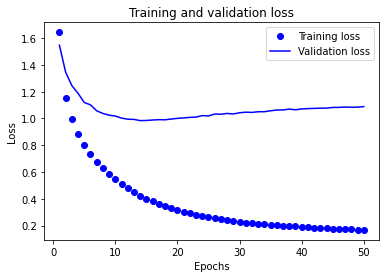

In [23]:
# validation loss 그래프 시각화
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
# 인코더 정의 
# encoder_inputs와 encoder_states는 이미 정의한 것들을 재사용
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 512)         2392576   
                                                                 
 masking (Masking)           (None, None, 512)         0         
                                                                 
 lstm (LSTM)                 [(None, 512),             2099200   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 4,491,776
Trainable params: 4,491,776
Non-trainable params: 0
_________________________________________________________________


In [25]:
# 디코더를 설계
decoder_state_input_h = Input(shape=(embedding_size,))
decoder_state_input_c = Input(shape=(embedding_size,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [26]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 512)    3820544     ['decoder_input[0][0]']          
                                                                                                  
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                            

In [27]:
# 단어에서 정수로, 정수에서 단어로 바꾸는 사전(dictionary)을 준비
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [28]:
# 예측 과정을 위한 함수 decode_sequence()를 구현

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <start>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['<start>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <end>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<end>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [29]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

In [30]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['<start>']) and i!=fra2idx['<end>']):
            temp = temp + idx2fra[i] + ' '
    return temp

In [31]:
# 훈련 데이터에 대한 결과를 테스트
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_train[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_train[seq_index])) # '<start>'와 '<end>'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[1:-5]) # '<end>'을 빼고 출력

-----------------------------------
입력 문장: hi . 
정답 문장: salut ! 
번역기가 번역한 문장: salut bien . 
-----------------------------------
입력 문장: hello ! 
정답 문장: salut ! 
번역기가 번역한 문장: salut ! ! ! 
-----------------------------------
입력 문장: hop in . 
정답 문장: montez . 
번역기가 번역한 문장: monte . . la
-----------------------------------
입력 문장: help me ! 
정답 문장: aide moi ! 
번역기가 번역한 문장: aide moi ! ! 
-----------------------------------
입력 문장: humor tom . 
정답 문장: mettez tom de bonne humeur . 
번역기가 번역한 문장: mets tom tom 


In [32]:
# 테스트 데이터에 대한 결과를 테스트
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index])) # '<start>'와 '<end>'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[1:-5]) # '<end>'을 빼고 출력

-----------------------------------
입력 문장: i want my key back . 
정답 문장: je veux que vous me rendiez ma cl . 
번역기가 번역한 문장: je veux ma m
-----------------------------------
입력 문장: i was almost right . 
정답 문장: j avais presque raison . 
번역기가 번역한 문장: j tais bien bi
-----------------------------------
입력 문장: i was very nervous . 
정답 문장: j tais tr s nerveuse . 
번역기가 번역한 문장: j tais bien 
-----------------------------------
입력 문장: i m going to flunk . 
정답 문장: je vais me planter . 
번역기가 번역한 문장: je m . . . . 
-----------------------------------
입력 문장: maybe you re right . 
정답 문장: peut tre avez vous raison . 
번역기가 번역한 문장: vous n si ai


## 정리
### - 훈련 데이터 결과

    입력 문장: hi . -> 안녕

    정답 문장: salut ! -> 안녕하세요 !

    번역기가 번역한 문장: salut bien . -> 안녕, 좋아.
-----------------------------------
    입력 문장: hello ! -> 안녕하세요 !

    정답 문장: salut ! -> 안녕하세요 !

    번역기가 번역한 문장: salut ! ! !  -> 안녕하세요 ! ! !
-----------------------------------
    입력 문장: hop in . -> 올라 타다

    정답 문장: montez . -> 위로 가다

    번역기가 번역한 문장: monte . . la -> 위로 가다. . 그만큼
-----------------------------------
    입력 문장: help me ! -> 도와주세요 !

    정답 문장: aide moi ! -> 도와주세요 !

    번역기가 번역한 문장: aide moi ! ! -> 도와주세요 ! !
-----------------------------------
    입력 문장: humor tom . -> 유머 톰

    정답 문장: mettez tom de bonne humeur . -> 톰을 기분 좋게 하다

    번역기가 번역한 문장: mets tom tom -> 톰 톰을 넣어

   - 조금 이상한 부분이 보이지만 대체로 비슷하게 번역하는 듯 하다

### - 테스트 데이터 결과

    입력 문장: i want my key back . -> 내 열쇠를 돌려받고 싶어

    정답 문장: je veux que vous me rendiez ma cl . -> 내 열쇠를 돌려주길 원해

    번역기가 번역한 문장: je veux ma m  -> 나는 내 m을 원한다
________
    입력 문장: i was almost right . -> 나는 거의 맞았다

    정답 문장: j avais presque raison . -> 내가 거의 맞았어

    번역기가 번역한 문장: j tais bien bi  -> 잘 지내요
____________
    입력 문장: i was very nervous . -> 나는 매우 긴장했다

    정답 문장: j tais tr s nerveuse . -> 나는 매우 긴장했다

    번역기가 번역한 문장: j tais bien -> 잘 지내요
____________
    입력 문장: i m going to flunk . -> 나는 쓰러지겠다

    정답 문장: je vais me planter . -> 나는 충돌 할거야

    번역기가 번역한 문장: je m . . . . -> 나는 . . . .
______________
    입력 문장: maybe you re right . -> 아마도 당신이 맞을 것입니다

    정답 문장: peut tre avez vous raison . -> 당신이 옳은 것 같다

    번역기가 번역한 문장: vous n si ai -> 너는 없다

  - 문장의 형태로 보면 아주 조금 비슷해 보이지만 한국어로 번역해 확인해보면 뜻이 매우 이상한 걸 확인할 수 있다.

### 회고
  - 과정 자체가 너무 어려워서 혼자 코드를 짜기에는 너무 힘들어서 다른 사람꺼를 참고해서 함.
  - 코드를 직접 짜보는 것보단 참고해서 진행 후 과정을 이해하는게 더 나은 듯
  - 훈련 데이터 결과는 비슷하게 나왔지만 테스트 데이터 결과는 거의 망함
  - 아마 훈련 데이터에 오버피팅 된 듯